In [1]:
#! pip install --quiet gensim

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

yelps = pd.read_csv('sentiment/yelps.csv')
yelps = yelps.sample(10000) # since otherwise training the Word2Vec model takes forever

In [3]:
from bs4 import BeautifulSoup
import re

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    
    
    token_pattern = r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(s)

    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 
    
    # Go to sklearn!

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
vectorizer = CountVectorizer(preprocessor = clean_yelp, tokenizer = tokenize)
TF = vectorizer.fit_transform(yelps.text) # TF matrix

# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.

# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

svd = TruncatedSVD(n_components = 100)
PCA = svd.fit_transform(TF) # truncated matrix

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix   -----> TF
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD ------> PCA

In [5]:
from sklearn.metrics import accuracy_score

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [6]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import math

# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

length = len(yelps.positive)

levels = []
for level in np.arange(0.05, 1, 0.05):
    levels.append(math.floor(length*level))  # creating the set of cutoff levels


accuracy_TF = [test_holdout_vectors(TF, yelps.positive, l) for l in levels]     # accuracy for TF
accuracy_PCA = [test_holdout_vectors(PCA, yelps.positive, l) for l in levels]   # accuracy for SVD

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

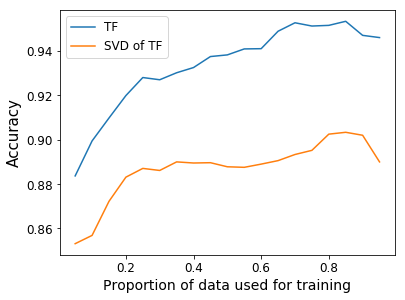

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4.5))
plt.plot(np.arange(0.05, 1, 0.05),accuracy_TF)
plt.plot(np.arange(0.05, 1, 0.05),accuracy_PCA)
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.legend(['TF','SVD of TF'],fontsize = 12)
plt.xlabel('Proportion of data used for training',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 15)
plt.show()

### From the above plot we see that here the word embeddings generated via SVD don't actually help us improve our accuracy score. 

In [9]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

sentences = [tokenize(clean_yelp(review)) for review in yelps.text]
model = Word2Vec(sentences=sentences, size=100, window=5, min_count=1, workers=3)

model.train(sentences, total_examples=1, epochs=2)

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


(1713638, 2230716)

In [43]:
display(model.wv.most_similar('good')) # check

[('decent', 0.8208804130554199),
 ('great', 0.7575884461402893),
 ('cheap', 0.7473102807998657),
 ('fantastic', 0.7426044344902039),
 ('big', 0.7363244295120239),
 ('bad', 0.7322441339492798),
 ('delicious', 0.731277585029602),
 ('fast', 0.721078097820282),
 ('tasty', 0.6933300495147705),
 ('wonderful', 0.6850572824478149)]

In [10]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis = 0)
    a /= np.linalg.norm(a)
    return a


# use as follows: np.array([embed_w2v(t, w2v) for t in X])

In [11]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

w2v_matrix = np.array([embed_w2v(t, model) for t in sentences])
accuracy_w2v = [test_holdout_vectors(w2v_matrix, yelps.positive, l) for l in levels]

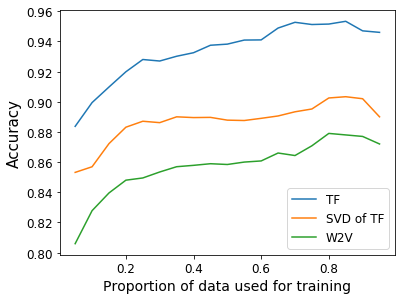

In [12]:
plt.figure(figsize=(6,4.5))
plt.plot(np.arange(0.05, 1, 0.05),accuracy_TF)
plt.plot(np.arange(0.05, 1, 0.05),accuracy_PCA)
plt.plot(np.arange(0.05, 1, 0.05),accuracy_w2v)
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.legend(['TF','SVD of TF', 'W2V'],fontsize = 12)
plt.xlabel('Proportion of data used for training',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 15)
plt.show()

#### In my case, apparently, the original TF matrix performs best again. The word2vec does not seem to give us any improvement unfortunately (this might be the case because I have only used a sample of 10000 of the 100000 Yelp reviews). In all cases, we observe best accuracy scores when about 80% of the data is used for training.

In [13]:
import pandas as pd
import re
from functools import reduce


def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """

    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    
    pattern1 = 'RT'              # RT's
    pattern2 = r'http\S+'        # URL's
    pattern3 = '@[\w_]+'         # mentions
    pattern4 = r'[^\x00-\x7F]+'  # emojis
    pattern5 = '(\n)'            # break lines
    pattern6 = '#'               # hashtag symbols (#), but will keep the text after since it (potentially) carries info 
    pattern7 = '&[\w_]+'         # unnecessary strings starting with &, such as &dsfsf
    pattern8 = '[^\w\s]'         # punctuation
   
    pattern = r'|'.join((pattern1, pattern2, pattern3, pattern4, pattern5, pattern6, pattern7, pattern8))
    s = re.sub(pattern, '', s)
            

    return s

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [16]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt', encoding="utf8") as f:
    tweets = pd.Series(f.readlines())

tweets = tweets.sample(10000) # so that my PC can handle it    

In [18]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

vectorizer_tweets = CountVectorizer(preprocessor=clean_twitter, tokenizer = tokenize)
TF_tweets = vectorizer_tweets.fit_transform(tweets) # tweets TF matrix


svd_tweets = TruncatedSVD(n_components = 100)
PCA_tweets = svd_tweets.fit_transform(TF_tweets) # tweets truncated matrix

In [19]:
sentences_tweets = [tokenize(clean_twitter(tweet)) for tweet in tweets]

model_tweets = Word2Vec(sentences_tweets, size=100, window=5, min_count=1, workers=4)

# model_tweets.train(sentences_tweets, total_examples=1, epochs=1)

In [21]:
w2v_tweets  = np.array([embed_w2v(t, model_tweets) for t in sentences_tweets]) # new embeddings

In [22]:
# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
# 
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math


display(model_tweets.wv.most_similar('trump'))
display(model_tweets.wv.most_similar('hillary'))
display(model_tweets.wv.most_similar(positive=['trump'], negative=['hillary']))

[('IranDeal', 0.9901905655860901),
 ('Make', 0.989959716796875),
 ('1st', 0.9899527430534363),
 ('Were', 0.9898191690444946),
 ('again', 0.9898044466972351),
 ('Trumps', 0.989797830581665),
 ('under', 0.9897888898849487),
 ('CNN', 0.9897711277008057),
 ('car', 0.989751935005188),
 ('rally', 0.9897215366363525)]

[('plant', 0.9617530703544617),
 ('DAY', 0.9617362022399902),
 ('CNNs', 0.9605816006660461),
 ('itself', 0.9605646133422852),
 ('WHITE', 0.9602869153022766),
 ('TIME', 0.9601298570632935),
 ('LIVE', 0.9599621295928955),
 ('Defends', 0.9599295854568481),
 ('Marco', 0.9598944187164307),
 ('HillaryHealth', 0.9598426222801208)]

[('TRAITOR', 0.3569955825805664),
 ('2headed', 0.3493725657463074),
 ('Alas', 0.3482903838157654),
 ('blowback', 0.3435736298561096),
 ('mission', 0.3273293375968933),
 ('fig', 0.3265083432197571),
 ('mutual', 0.32633736729621887),
 ('screeching', 0.3237682580947876),
 ('messed', 0.32353222370147705),
 ('organist', 0.3209179639816284)]

In [23]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

In [31]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

In [59]:
tweets = tweets.reset_index(drop=True)
idxs = np.random.randint(0, high = len(tweets), size = 5) # creating random indexes

In [60]:
idxs

array([6000, 9058, 8252, 2524, 8290])

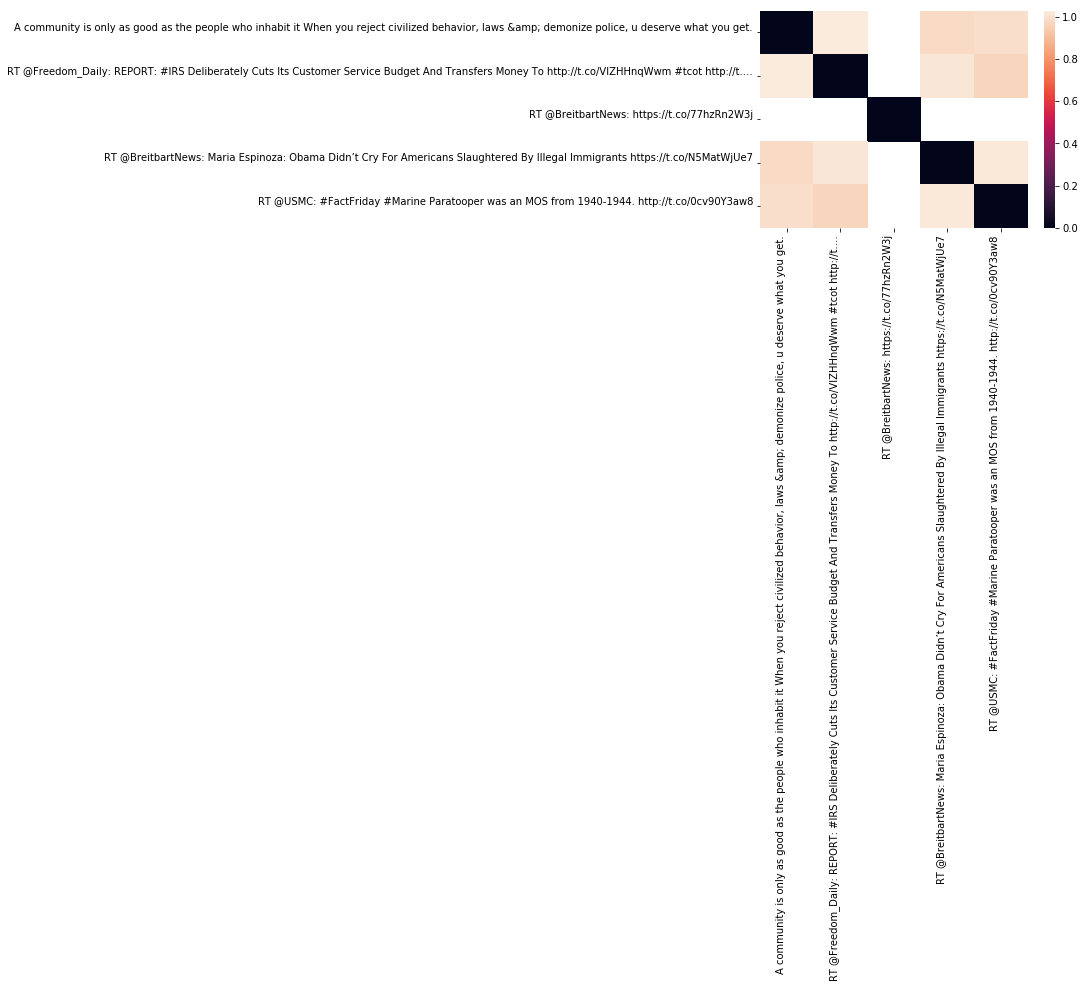

In [61]:
visualize_dist(PCA_tweets, tweets, idxs)

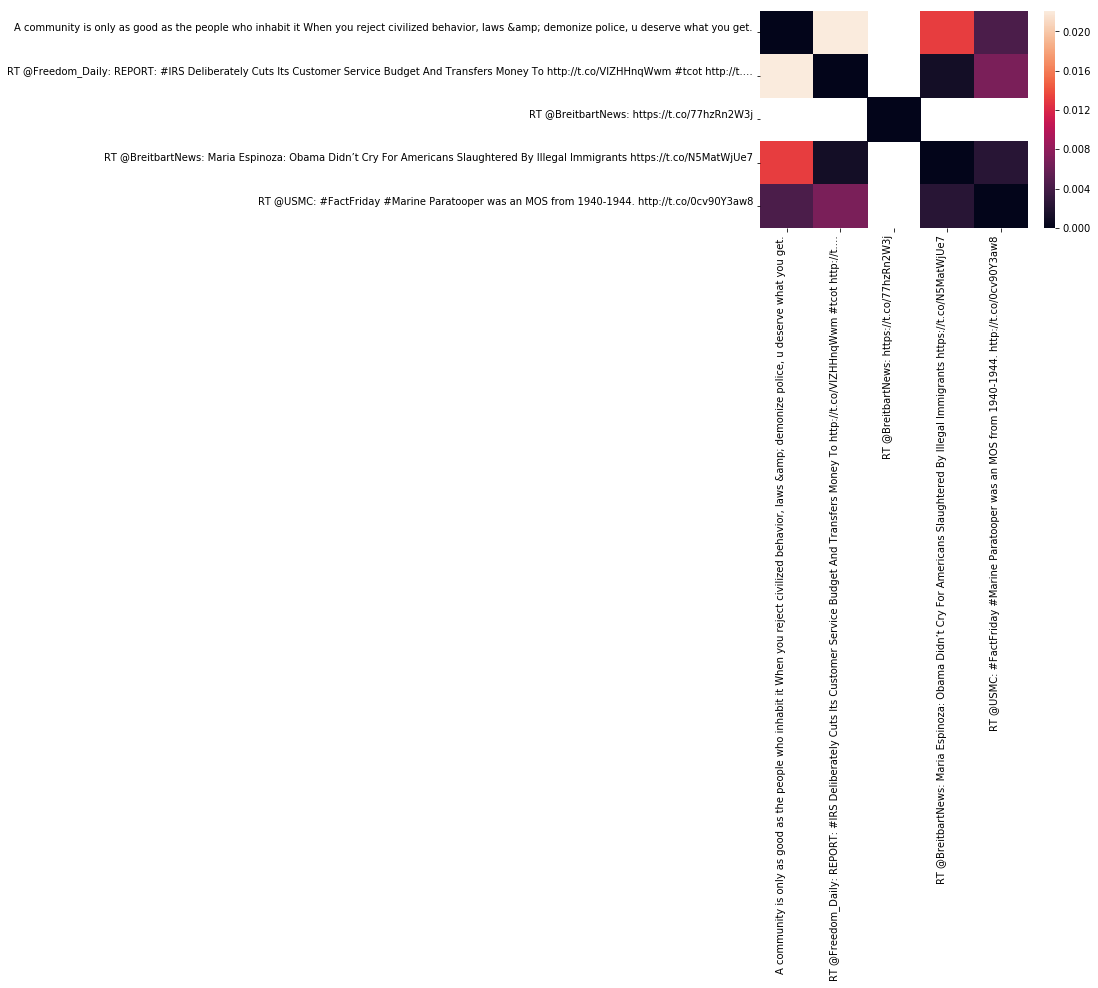

In [62]:
visualize_dist(w2v_tweets, tweets, idxs)

#### The models seem to produce good results overall. With this random set of indexes, we see that the 3rd tweet is as far as possible from all the others. That makes perfect sense since it only consists of an RT, a mention, and a URL, so it is completely empty after the cleaning.